##正向传播和反向传播实现
* 反向传播算法

之前我们在计算神经网络预测结果的时候我们采用了一种正向传播方法，我们从第一层开始正向一层一层进行计算，直到最后一层的$h_{\theta}\left(x\right)$。

现在，为了计算代价函数的偏导数$\frac{\partial}{\partial\Theta^{(l)}_{ij}}J\left(\Theta\right)$，我们需要采用一种反向传播算法，也就是首先计算最后一层的误差，然后再一层一层反向求出各层的误差，直到倒数第二层

### 可视化数据
利用上一周的数据，先计算神经网络前向传播算法，计算输出结果，为后向传播提供预测数据

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = loadmat('../data/andrew_ml_ex33507/ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = data['X']
y = data['y']

X.shape, y.shape#看下维度

((5000, 400), (5000, 1))

In [4]:
# 目前考虑输入是图片的像素值，20*20像素的图片有400个输入层单元，不包括需要额外添加的加上常数项。 材料已经提供了训练好的神经网络的参数,有25个单元和10个输出单元（10个输出）
weight = loadmat("../data/andrew_ml_ex33507/ex3weights.mat")
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

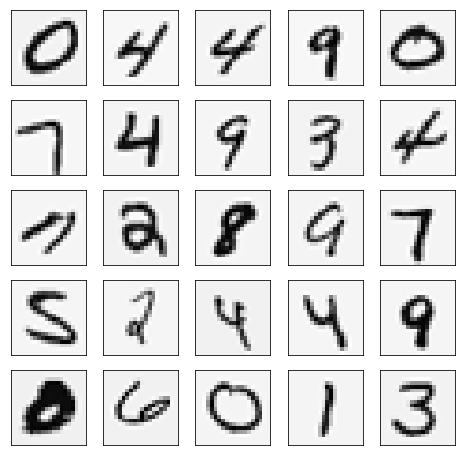

In [6]:
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 100)
sample_images = data['X'][sample_idx, :]
#展示二进制图
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(8, 8))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(sample_images[5 * r + c].reshape((20, 20))).T,cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

## 模型展示

按照默认 我们设计一个输入层，一个隐藏层，一个输出层

前向传播和代价函数


在逻辑回归中，我们只有一个输出变量，又称标量（scalar），也只有一个因变量$y$，但是在神经网络中，我们可以有很多输出变量，我们的$h_\theta(x)$是一个维度为$K$的向量，并且我们训练集中的因变量也是同样维度的一个向量，因此我们的代价函数会比逻辑回归更加复杂一些，为：$\newcommand{\subk}[1]{ #1_k }$ $$h_\theta\left(x\right)\in \mathbb{R}^{K}$$ $${\left({h_\theta}\left(x\right)\right)}_{i}={i}^{th} \text{output}$$

$J(\Theta) = -\frac{1}{m} \left[ \sum\limits_{i=1}^{m} \sum\limits_{k=1}^{k} {y_k}^{(i)} \log \subk{(h_\Theta(x^{(i)}))} + \left( 1 - y_k^{(i)} \right) \log \left( 1- \subk{\left( h_\Theta \left( x^{(i)} \right) \right)} \right) \right] + \frac{\lambda}{2m} \sum\limits_{l=1}^{L-1} \sum\limits_{i=1}^{s_l} \sum\limits_{j=1}^{s_{l+1}} \left( \Theta_{ji}^{(l)} \right)^2$


In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [62]:
#2st 上面传播规律,定义第一层，并计算第二层（隐藏层）的值,并添加额外值
def forward_propagate(X,theta1,theta2):
    m= X.shape[0]
    a1 = np.insert(X,0, values=np.ones(m), axis=1)
    Z2 = a1*theta1.T
    a2=  np.insert(sigmoid(Z2),0, values=np.ones(m), axis=1)
    Z3= a2*theta2.T
    h= sigmoid(Z3)
    return a1,Z2,a2,Z3,h 

In [14]:
# 代价函数（不带规则化项（也叫权重衰减项） Y=R(5000*10) ,这里直接使用二维矩阵，代替循环累加
def cost(X,Y,theta1,theta2):
    m = X.shape[0]
    X = np.matrix(X)
    Y = np.matrix(Y)
    h=forward_propagate(X,theta1,theta2)
    # multiply 矩阵size相同对应相乘
    first = np.multiply(Y,np.log(h))
    second = np.multiply((1-Y),np.log((1-h)))
    J= np.sum(first+second)
    J = (-1/m)*J
    return J

In [11]:
# 对y标签进行编码 一开始我们得到的y是维500*1 的向量，但我们要把他编码成的矩阵。 比如说，原始y0=2，那么转化后的Y对应行就是[0,1,0...0]，原始转化后的Y对应行就是[0,0...0,1]
# Scikitlearn有一个内置的编码函数，我们可以使用这个。
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [12]:
y[0], y_onehot[0,:] # y0是数字0

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [ ]:
# 初始化设置
input_size = 400
num_labels = 10

In [15]:
cost(X, y_onehot,theta1, theta2)

(5000, 10)


0.2876291651613189

In [76]:
# 加入正则项
def cost_reg(X,Y,theta1,theta2,learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    Y = np.matrix(Y)
    _,_,_,_,h=forward_propagate(X,theta1,theta2)
    first = np.multiply(Y,np.log(h))
    second = np.multiply((1-Y),np.log((1-h)))
    J= np.sum(first+second)
    # 计算正则时，第一项时不参与计算
    J = (-1/m)*J + (float(learning_rate) / (2 * m))*(np.sum(np.power(theta1[:,1:],2))+np.sum(np.power(theta2[:,1:],2)))
    return J

In [165]:
# theta1.shape,theta2.shape
cost_reg(X, y_onehot,theta1, theta2,1)

0.38376985909092365

## 反向传播
这一部分需要你实现反向传播的算法，来计算神经网络代价函数的梯度。获得了梯度的数据，我们就可以使用工具库来计算代价函数的最小值。

In [24]:
# 计算sigmoid函数的导数
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z) ,(1-sigmoid(z)))
# 检查
sigmoid_gradient(0)

0.25

##  初始话参数
到目前为止我们都是初始所有参数为0，这样的初始方法对于逻辑回归来说是可行的，但是对于神经网络来说是不可行的。如果我们令所有的初始参数都为0，这将意味着我们第二层的所有激活单元都会有相同的值。同理，如果我们初始所有的参数都为一个非0的数，结果也是一样的。

我们通常初始参数为正负ε之间的随机值，假设我们要随机初始一个尺寸为10×11的参数矩阵，代码如下：

Theta1 = rand(10, 11) (2eps) – eps

In [117]:
# 初始化设置
input_size = 400 #输入单元数量
hidden_size = 25 # y隐藏单元数量
num_labels = 10 # 输出单元数
epsilon = 0.001
theta01=np.random.rand(hidden_size,input_size+1) * 2*epsilon - epsilon# +1是添加偏置单元
theta02 =np.random.rand(num_labels,hidden_size+1)* 2*epsilon - epsilon
theta01.shape,theta02.shape

((25, 401), (10, 26))

### 反向传播

反向传播的步骤是，给定训练集，先计算正向传播，再对于层的每个节点，计算误差项，这个数据衡量这个节点对最后输出的误差“贡献”了多少。 对于每个输出节点，我们可以直接计算输出值与目标值的差值，定义为δ。对于每个隐藏节点，需要基于现有权重及（l+1）层的误差，计算


** 步骤：**

1.  随机初始化权重theta
2.  实现前向传递对任何xi 都能取得h（xi）
3. 实现Jθ
4. ![反向传播步骤](../img/bp.png)

In [216]:
# 分别得出
def forward_propagateNEW(X,thetalist):
    m= X.shape[0]
    a = np.insert(X,0, values=np.ones(m), axis=1)
    alist=[a]
    zlist=[]
    for i in range(len(thetalist)):
        theta= thetalist[i]
        z = a * theta
        # a= np.insert(sigmoid(z),0, values=np.ones(m), axis=1)
        a=sigmoid(z)
        if(i<len(thetalist)-1):
            a= np.insert(a,0, values=np.ones(m), axis=1)
        zlist.append(z)
        alist.append(a)
    return zlist,alist

In [333]:
# Δ 用delta1 和delta2 替代
def backpropRegSelf(input_size, hidden_size, num_labels, X, y, learning_rate,L=3):  # 随机化后的  这里为3层 
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    #初始化参数
    theta1 = (np.random.random((input_size+1,hidden_size))- 0.5)* 0.24
    theta2 = (np.random.random((hidden_size+1,num_labels))- 0.5)* 0.24
    encoder = OneHotEncoder(sparse=False)
    y_onehot  = encoder.fit_transform(y) # 格式化y 
    # 前向计算 每层值
    theta = [theta1, theta2]
    zlist,alist = forward_propagateNEW(X, theta)# 返回 a1 z2 a2 。。。
    # 初始化Deta
    Delta=[]
    for th in theta:
        Delta.append(np.zeros(th.shape))
    for i in range(m):
        # 以计算a z
        for l in range(L,1,-1): # 3,2 表示层数，最后一层已经算出来，单独列放
            #最后一层
            if l==L:
                delta=alist[-1][i,:]-y_onehot[i,:] # 最后一层得δ
                Delta[l-2] = Delta[l-2] +   alist[l-2][i,:].T  * delta
            else:
                zl = zlist[l-2][i,:]
                zl = np.insert(zl, 0, values=np.ones(1))  # (1, 26) 怎加偏执项
                # d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
                # delta1 = delta1 + (d2t[:,1:]).T * a1t
                delta = np.multiply(delta*theta[l-1].T, sigmoid_gradient(zl))  # 
                 # 因为数组从零开始，且 Delta 为 1 2 层开始 delta 从2 层开始   # (25, 401)# (10, 26)
                Delta[l-2] = Delta[l-2] +   alist[l-2][i,:].T  * delta[:,1:]      
    # add the gradient regularization term
    gradAll = None
    for j in range(len(Delta)):
        Delta[j][:,1:] = Delta[j][:,1:]/m + (theta[j][:,1:] * learning_rate) / m
        if gradAll is None:
            gradAll = np.ravel(Delta[j])
        else:
            tmp=np.ravel(Delta[j]) 
            gradAll = np.concatenate([gradAll,tmp])
    # Delta[:,:,1:] = Delta[:,:,1:] + (theta[:,:,1:] * learning_rate) / m
    return  gradAll


In [334]:
grad2= backpropRegSelf(input_size, hidden_size, num_labels, X, y, 1)
print(grad2.shape)


(10285,)


In [97]:
def backpropReg(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    # perform backpropagation
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = y[t,:]  # (1, 10)
        
        d3t = ht - yt  # (1, 10)
        
        z2t = np.insert(z2t, 0, values=np.ones(1))  # (1, 26)
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t))  # (1, 26)
        
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [289]:
# np.random.random(size) 返回size大小的0-1随机浮点数
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.24
j,grad = backpropReg(params, input_size, hidden_size, num_labels, X, y, 1)
print(j,grad.shape)
# j2,grad2= backpropRegSelf(input_size, hidden_size, num_labels, X, y, 1)
# print(j2,grad2[0:10])

-316.99610886180704 (10285,)


### 梯度检验

梯度的估计采用的方法是在代价函数上沿着切线的方向选择离两个非常近的点然后计算两个点的平均值用以估计梯度。即对于某个特定的 $\theta$，我们计算出在 $\theta$-$\varepsilon $ 处和 $\theta$+$\varepsilon $ 的代价值（$\varepsilon $是一个非常小的值，通常选取 0.001），然后求两个代价的平均，用以估计在 $\theta$ 处的代价值。

In [175]:
# #J θ
# input_size = 400 #输入单元数量
# hidden_size = 25 # y隐藏单元数量
# num_labels = 10 # 输出单元数
def jcost(X, y,input_size, hidden_size, output_size,theta):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    theta1 = np.reshape(theta[0:hidden_size*(input_size+1)],(hidden_size,input_size+1))#(25,401)
    theta2 = np.reshape(theta[hidden_size*(input_size+1):],(output_size,hidden_size+1))#(10.26)
    _,_,_,_,h=forward_propagate(X,theta1,theta2)
    # multiply 矩阵size相同对应相乘
    first = np.multiply(y,np.log(h))
    second = np.multiply((1-y),np.log((1-h)))
    J= np.sum(first+second)
    J = (-1/m)*J
    return J


In [176]:
def check(X,y,theta1,theta2,eps):
    theta = np.concatenate((np.ravel(theta1), np.ravel(theta2)))
    gradapprox=np.zeros(len(theta))
    for i in range(len(theta)):
        thetaplus = theta
        thetaplus[i] = thetaplus[i] + eps
        thetaminus = theta
        thetaminus[i] = thetaminus[i] - eps
        gradapprox[i] = (jcost(X,y,input_size,hidden_size,num_labels,thetaplus) - jcost(X,y,input_size,hidden_size,num_labels,thetaminus)) / (2 * epsilon)
    return gradapprox

In [335]:
#  theta01.shape , theta02.shape 
# 计算很慢
gradapprox = check(X,y_onehot,theta1,theta2,0.001)
numerator = np.linalg.norm(grad2-gradapprox, ord=2)                                           # Step 1'
denominator = np.linalg.norm(grad2, ord=2) + np.linalg.norm(gradapprox, ord=2)                                         # Step 2'
difference = numerator / denominator
print(difference)

1.0


In [99]:
#  使用工具库计算参数最优解
from scipy.optimize import minimize
# opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
fmin = minimize(fun=backpropReg, x0=(params), args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

     fun: 0.33051628793941373
     jac: array([-1.30423244e-04, -5.41296628e-08, -9.69885832e-08, ...,
        1.70760830e-04,  2.81803084e-04,  3.14043188e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 20
  status: 3
 success: False
       x: array([ 7.56428972e-01, -2.70648314e-04, -4.84942916e-04, ...,
       -9.28865498e-01,  1.14566495e+00,  3.01340668e-01])

In [189]:
X = np.matrix(X)
thetafinal1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
thetafinal2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

In [343]:
print(thetafinal1[0,1],grad2[1])

-0.0002706483141056426 0.00382229520426484


In [190]:
# 计算使用优化后的θ得出的预测
a1, z2, a2, z3, h = forward_propagate(X, thetafinal1, thetafinal2 )
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [191]:
# 最后，我们可以计算准确度，看看我们训练完毕的神经网络效果怎么样。
# 预测值与实际值比较
from sklearn.metrics import classification_report#这个包是评价报告
print(classification_report(y, y_pred))

precision    recall  f1-score   support

           1       0.99      1.00      0.99       500
           2       0.99      0.99      0.99       500
           3       0.99      0.98      0.99       500
           4       1.00      0.99      0.99       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      0.99      0.99       500
           8       0.99      1.00      1.00       500
           9       0.99      0.98      0.98       500
          10       0.99      1.00      1.00       500

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [103]:
hidden_layer = thetafinal1[:, 1:] 
hidden_layer.shape

(25, 400)

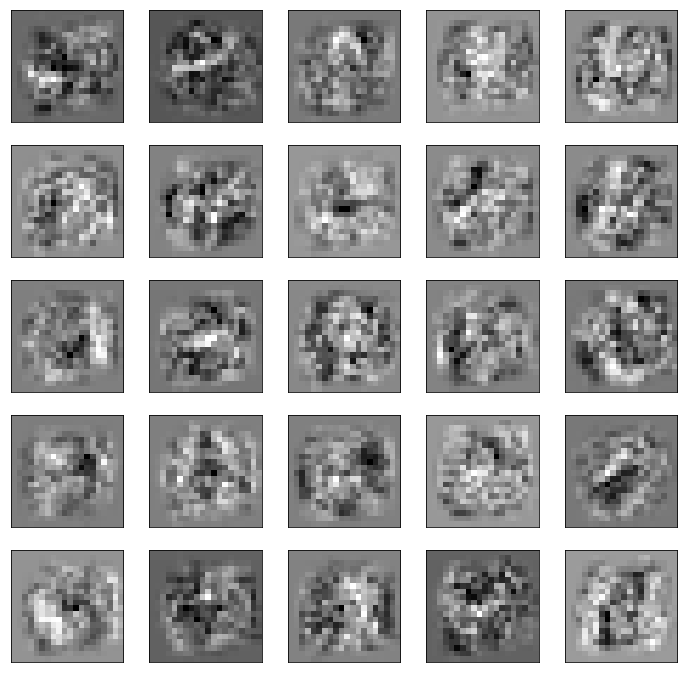

In [104]:
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(12, 12))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(hidden_layer[5 * r + c].reshape((20, 20))),cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 
